In [98]:
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

In [43]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/SwingTrader')

In [99]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
from dataloaders import get_data_from_yahoo

In [121]:
ticker = "MSFT"

In [122]:
start_date = "2022-01-01"
end_date = "2023-03-31"

In [123]:
stock = get_data_from_yahoo.get_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
connected to yahoo


In [124]:
def bollinger_bands(df, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [125]:
def computeRSI(data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [126]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(stock, 20, 2)

In [127]:
df['RSI'] = computeRSI(df['Adj Close'], 14)

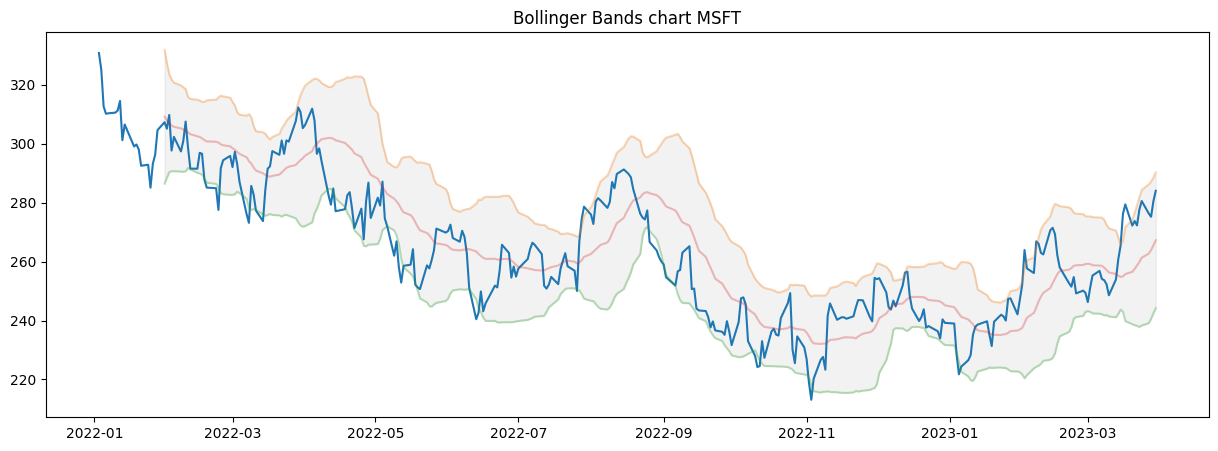

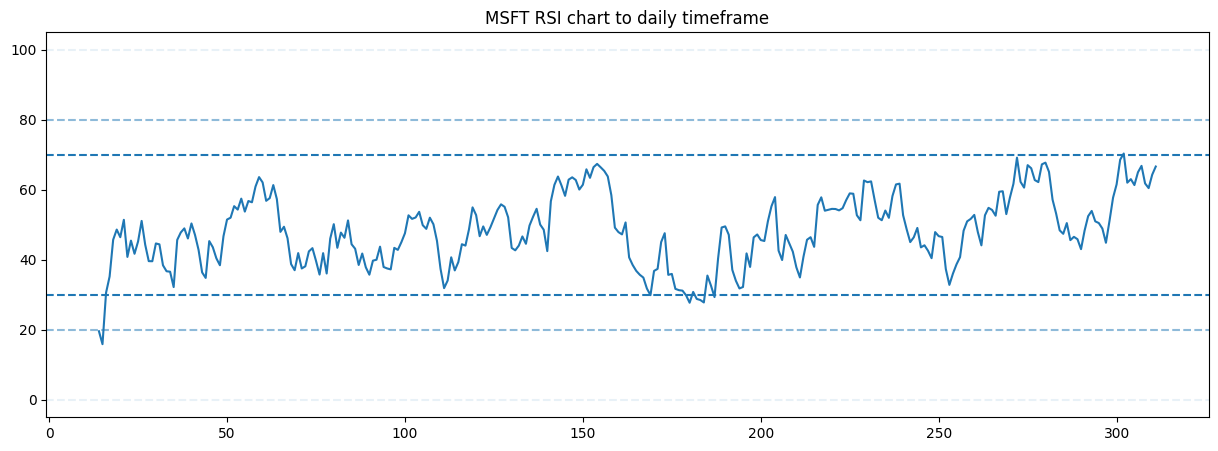

In [128]:
# plot price
'''
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()
'''
# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(ticker))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BU'], alpha=0.3)
plt.plot(df['Date'], df['BL'], alpha=0.3)
plt.plot(df['Date'], df['B_MA'], alpha=0.3)
plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

# plot corresponding RSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.title('{} RSI chart to {} timeframe'.format(ticker, 'daily'))
plt.plot(df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)

plt.show()

In [129]:
#### RESAMPLING TO WEEKLY TO CLEAN NOISE

agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
df.set_index('Date', inplace=True)
df_agg = df.resample('W').agg(agg_dict)
df_agg = df_agg.reset_index()

In [130]:
# add BB columns
n = 20   # datapoint rolling window
m = 2    # sigma width
df_agg = bollinger_bands(df_agg, 20, 2)

In [131]:
def add_signal(df):
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    
    for i in range(len(df['Close'])):
        #if df['Close'][i] > df['BU'][i]:           # sell signal     daily
        if df['High'][i] > df['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(df['Close'][i])
        #elif df['Close'][i] < df['BL'][i]:         # buy signal      daily
        elif df['Low'][i] < df['BL'][i]:            # buy signal      weekly
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [132]:
df_agg['RSI'] = computeRSI(df_agg['Adj Close'], 14)

In [133]:
def plot_signals(df, ticker):
    # plot price
    #plt.figure(figsize=(15,5))
    #plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    #plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close')

    plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell'], label='Sell', marker='v')

    plt.figure(figsize=(15,5))
    plt.title('RSI chart')
    plt.title('{} RSI chart to {} timeframe'.format(ticker, 'weekly'))
    plt.plot(df['RSI'])

    plt.axhline(0, linestyle='--', alpha=0.1)
    plt.axhline(20, linestyle='--', alpha=0.5)
    plt.axhline(30, linestyle='--')

    plt.axhline(70, linestyle='--')
    plt.axhline(80, linestyle='--', alpha=0.5)
    plt.axhline(100, linestyle='--', alpha=0.1)

    plt.legend()

    plt.show()

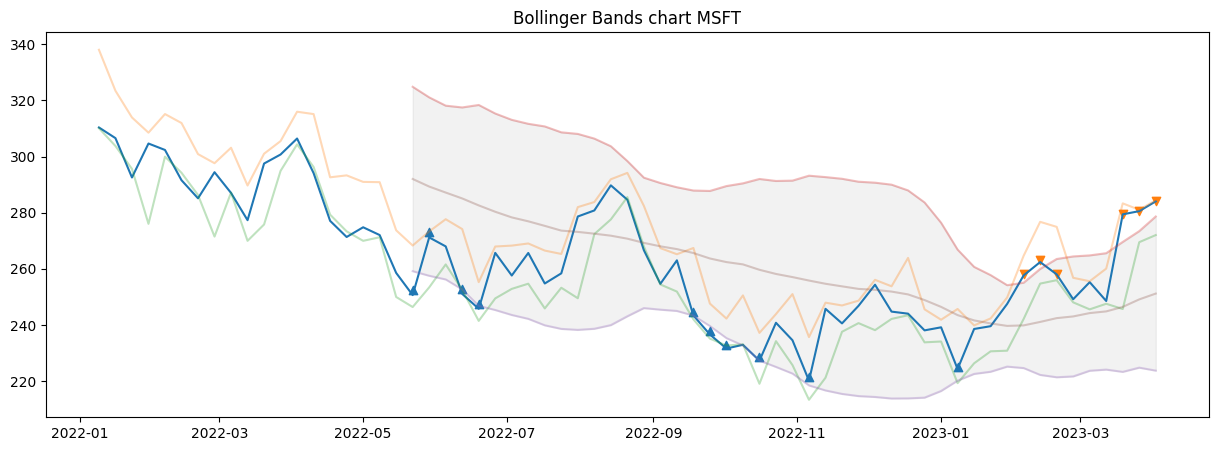

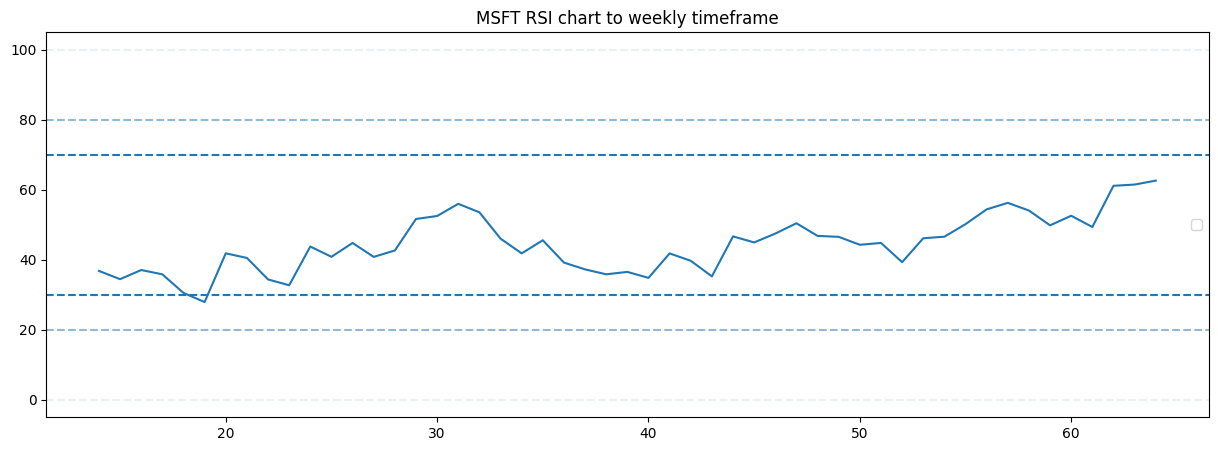

In [134]:
df_agg = add_signal(df_agg)
plot_signals(df_agg, ticker)